<a href="https://colab.research.google.com/github/AndreiAf02/STAT561_Project/blob/main/STAT561_Project_Code_V4_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##STAT 561 Project - Predicting Heart Disease From Diabetes with Transfer Learning

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
# !pip install pytorch-tabnet

# from pytorch_tabnet.tab_model import TabNetClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



## Data taken from the UCI Machine Learning repository [here](https://doi.org/10.24432/C53919):

In [3]:
pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)



In [5]:
data = cdc_diabetes_health_indicators.data
# data (as pandas dataframes)
X = data.features
y = data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [6]:
X.iloc[:,6]

,HeartDiseaseorAttack
0,0
1,0
2,0
3,0
4,0
...,...
253675,0
253676,0
253677,0
253678,0


In [7]:
## Scaling the predictive data

scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled)

In [8]:
data2 = pd.concat([X_scaled, y], axis=1)
data2

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.00,0.6,0.500000,1.0,0.0,0.666667,0.6,0.285714,0
1,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.50,0.0,0.000000,0.0,0.0,0.500000,1.0,0.000000,0
2,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.00,1.0,1.000000,1.0,0.0,0.666667,0.6,1.000000,0
3,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.0,0.000000,0.0,0.0,0.833333,0.4,0.714286,0
4,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,0.1,0.000000,0.0,0.0,0.833333,0.8,0.428571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1.0,1.0,1.0,0.383721,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.166667,0.0,1.0,0.333333,1.0,0.857143,0
253676,1.0,1.0,1.0,0.069767,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.75,0.0,0.000000,1.0,0.0,0.833333,0.2,0.428571,1
253677,0.0,0.0,1.0,0.186047,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.083333,0.8,0.142857,0
253678,1.0,0.0,1.0,0.127907,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.50,0.0,0.000000,0.0,1.0,0.500000,0.8,0.000000,0


In [9]:
y.value_counts()

,count
Diabetes_binary,
0,218334
1,35346


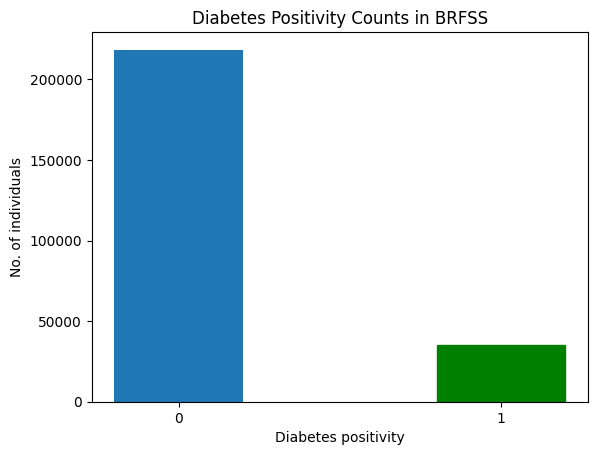

In [10]:
barlist = plt.bar([str(0),str(1)], y.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS")
plt.show()

# Splitting for Source and Target Domains:


# Full Dataset:

In [11]:
data_S = data2.sample(frac=0.90, random_state=42)
data_S_X = data_S.drop(data_S.columns[[6, 21]], axis=1)
data_S_y = data_S.iloc[:, 21]    ## Response variable of interest is Diabetes

data_S_full = pd.concat([data_S_X, data_S_y], axis=1)

data_T = data2.drop(data_S.index)
data_T_X = data_T.drop(data_T.columns[[6, 21]], axis=1)
data_T_y = data_T.iloc[:, 6]    ## Response variable of interest in Heart Disease

data_T_full = pd.concat([data_T_X, data_T_y], axis=1)

In [12]:
data_T_full

,0,1,2,3,4,5,7,8,9,10,...,12,13,14,15,16,17,18,19,20,6
5,1.0,1.0,1.0,0.151163,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.25,0.000000,0.066667,0.0,1.0,0.750000,1.0,1.000000,0.0
15,1.0,0.0,1.0,0.244186,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.25,0.166667,0.000000,0.0,0.0,0.416667,1.0,1.000000,0.0
26,1.0,1.0,1.0,0.290698,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.00,0.000000,0.000000,1.0,1.0,0.750000,1.0,0.571429,1.0
28,1.0,1.0,1.0,0.174419,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.75,0.666667,0.666667,1.0,0.0,0.583333,0.6,0.857143,0.0
36,1.0,1.0,1.0,0.139535,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.50,0.166667,0.100000,1.0,1.0,0.583333,0.6,0.285714,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253650,1.0,0.0,1.0,0.174419,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.75,0.000000,0.000000,0.0,0.0,0.333333,0.6,0.142857,0.0
253651,0.0,0.0,1.0,0.139535,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.00,0.000000,0.000000,0.0,1.0,0.083333,1.0,0.285714,0.0
253654,0.0,0.0,1.0,0.162791,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.25,0.033333,0.000000,0.0,1.0,0.166667,0.4,0.000000,0.0
253656,0.0,0.0,1.0,0.151163,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.00,0.000000,0.000000,0.0,0.0,0.250000,1.0,1.000000,0.0


In [13]:
data_T_y

,6
5,0.0
15,0.0
26,1.0
28,0.0
36,0.0
...,...
253650,0.0
253651,0.0
253654,0.0
253656,0.0


## Source domain and task labels:

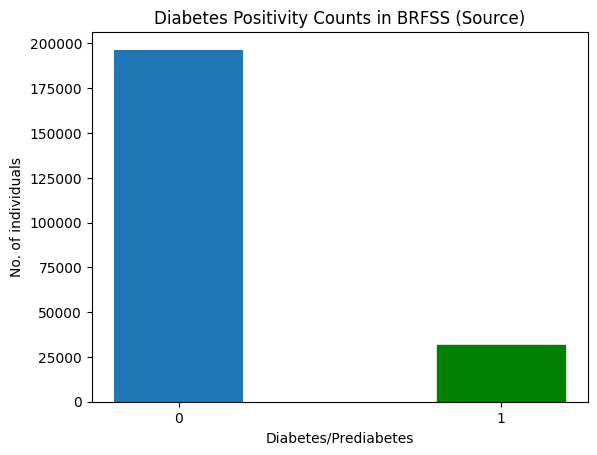

In [14]:
barlist_S = plt.bar([str(0),str(1)], data_S_y.value_counts(), width = 0.4)
barlist_S[1].set_color('g')

plt.xlabel("Diabetes/Prediabetes")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Source)")
plt.show()

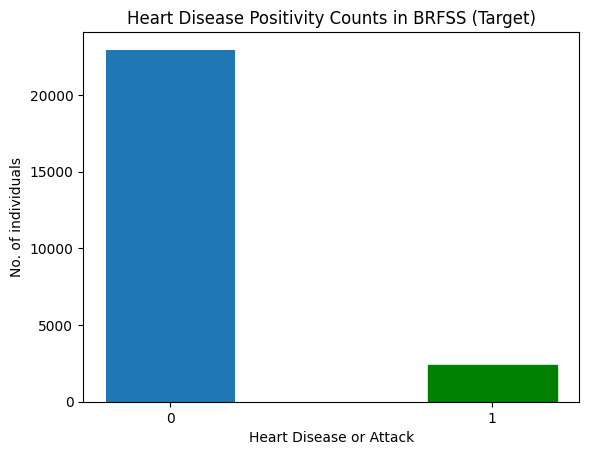

In [15]:
barlist_T = plt.bar([str(0),str(1)], data_T_y.value_counts(), width = 0.4)
barlist_T[1].set_color('g')

plt.xlabel("Heart Disease or Attack")
plt.ylabel("No. of individuals")
plt.title("Heart Disease Positivity Counts in BRFSS (Target)")
plt.show()

## Updated Code (Modified from Shreya's code):

In [16]:
def create_dnn_model(input_shape):
  model = models.Sequential([layers.Dense(64, activation='relu', input_dim=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification (yes/no diabetes)
    ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

  return model



def train_and_evaluate(model, X_train, X_test, y_train, y_test, domain):

    time_start = perf_counter()

    # Training and validation
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

    return model


In [17]:
def Transductive_TL(model, X_test, y_test, domain):

    time_start = perf_counter()

    # Predict probabilities and calculate AUC
    y_pred_prob = model.predict(X_test).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    print(f"AUC-ROC: {auc}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

    # Convert probabilities to binary predictions for confusion matrix
    y_pred_class = (y_pred_prob >= 0.5).astype(int)

    # Compute and print classification report
    class_report = classification_report(y_test, y_pred_class)
    print("Classification Report:")
    print(class_report)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred_class)
    conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

    # Plot ROC curve and Confusion Matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC Curve
    ax1.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc:.2f}')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax1.legend(loc='lower right')
    ax1.grid()

    # Confusion Matrix
    # print('Confusion matrix:', conf_matrix)
    fpr = conf_matrix[0][1]/(conf_matrix[0][0]+conf_matrix[0][1])
    tnr = 1-fpr

    fnr = conf_matrix[1][0]/(conf_matrix[1][0] + conf_matrix[1][1])
    tpr = 1 - fnr
    print('FPR', fpr, 'TPR:', tpr, 'FNR:', fnr, 'TNR:', tnr)
    conf_disp.plot(ax=ax2, cmap='Blues')
    ax2.set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

    # Find the threshold where precision and recall are balanced
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[f1_scores.argmax()]

    print(f"Best threshold based on F1-score: {best_threshold}")
    print('False Negative Rate:', fnr)

    time_stop = perf_counter()

    print('Time elapsed (performance):', time_stop-time_start)

In [18]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(data_S_X, data_S_y, test_size=0.20, random_state=0)

In [19]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (182649, 20)
y_S_train: (182649,)
X_S_test: (45663, 20)
y_S_test: (45663,)


In [19]:
model_source = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
4567/4567 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - AUC: 0.7793 - loss: 0.3433 - val_AUC: 0.8183 - val_loss: 0.3215
Epoch 2/10
4567/4567 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8196 - loss: 0.3200 - val_AUC: 0.8201 - val_loss: 0.3196
Epoch 3/10
4567/4567 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8244 - loss: 0.3156 - val_AUC: 0.8216 - val_loss: 0.3184
Epoch 4/10
4567/4567 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8263 - loss: 0.3130 - val_AUC: 0.8234 - val_loss: 0.3196
Epoch 5/10
4567/4567 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8252 - loss: 0.3136 - val_AUC: 0.8224 - val_loss: 0.3216
Epoch 6/10
4567/4567 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - AUC: 0.8277 - loss: 0.3124 - val_AUC: 0.8231 - val_loss: 0.3170
Epoch 7/10
4567/4567 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.8279 - loss: 0.3120 - val_AUC: 0.8233 - val_loss: 0.3169
Epoch 8/10
4567/4567 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8293 - loss: 0.3109 - val_AUC: 0.8251 - val_loss: 0.3156
Epoch 9/10
4567/4567 ━━━━━━━━━━━

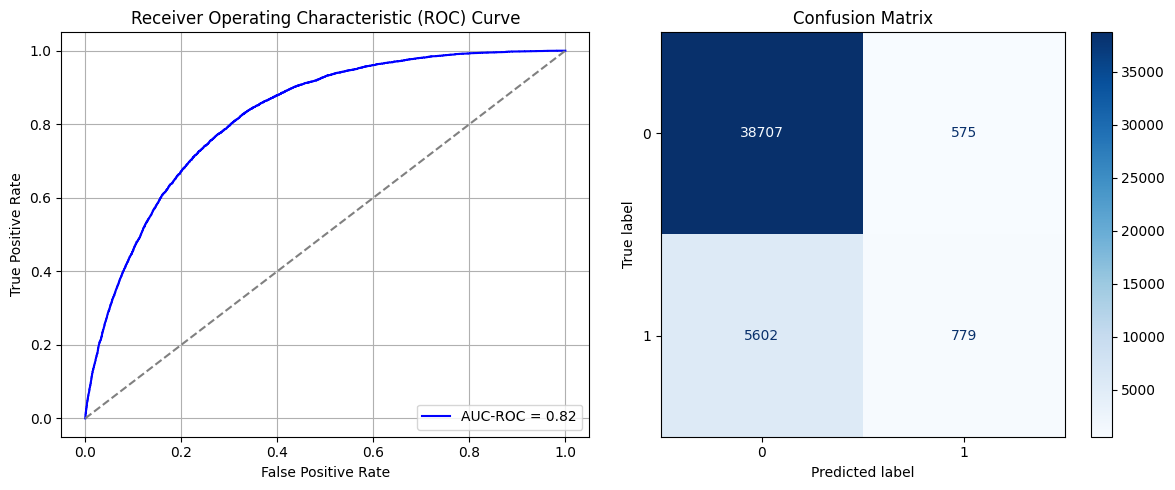

Best threshold based on F1-score: 0.21449017524719238
Time elapsed (performance): 145.17979606300105


<Sequential name=sequential, built=True>

In [20]:
train_and_evaluate(model_source, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC-ROC: 0.7994835781833445
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94     22957
         1.0       0.35      0.11      0.16      2411

    accuracy                           0.90     25368
   macro avg       0.63      0.54      0.55     25368
weighted avg       0.86      0.90      0.87     25368

FPR 0.021170013503506557 TPR: 0.10742430526752389 FNR: 0.8925756947324761 TNR: 0.9788299864964934


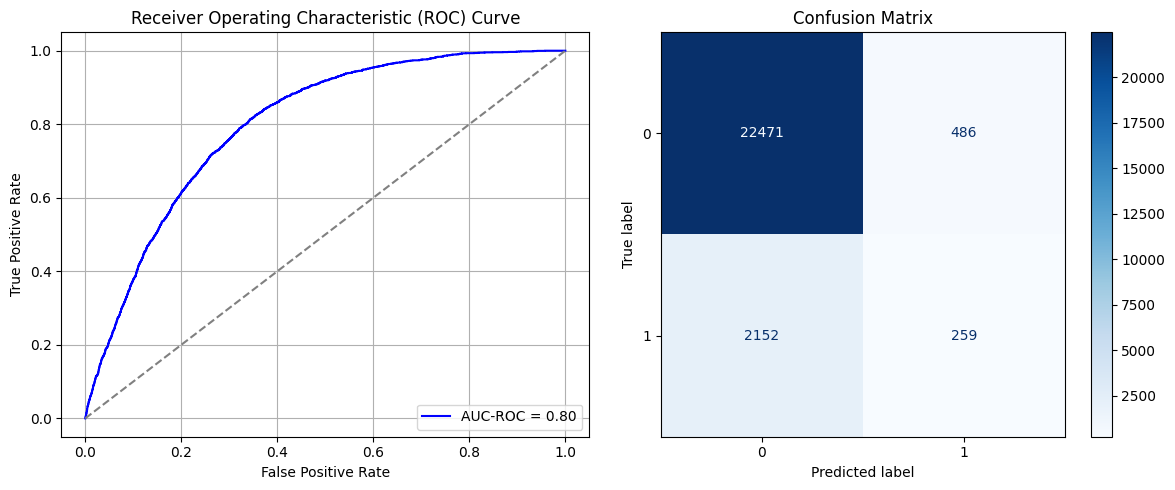

Best threshold based on F1-score: 0.21375826001167297
False Negative Rate: 0.8925756947324761
Time elapsed (performance): 3.0871866540001065


In [21]:
Transductive_TL(model_source, data_T_X, data_T_y, "Target")

# Random Undersampling (RUS) to balance Dataset:

## SRS Sample without Replacement:

In [25]:
data_S_full
data_S_majority = data_S_full[data_S_full['Diabetes_binary'].isin([0])]
data_S_minority = data_S_full[data_S_full['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

31806
196506


In [26]:
np.random.seed(123)
data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=False)
# print(data_S_maj_rus)

data_S_SRS_RUS = pd.concat([data_S_maj_rus, data_S_minority])
# print(data_S_SRS_RUS)

X_S_SRS = data_S_SRS_RUS.iloc[:, :20]
X_S_SRS      ## Source domain


y_S_SRS = data_S_SRS_RUS.iloc[:, 20]
y_S_SRS       ## Source classification (response)

,Diabetes_binary
36521,0
195710,0
90191,0
179224,0
22910,0
...,...
211634,1
207646,1
191755,1
92981,1


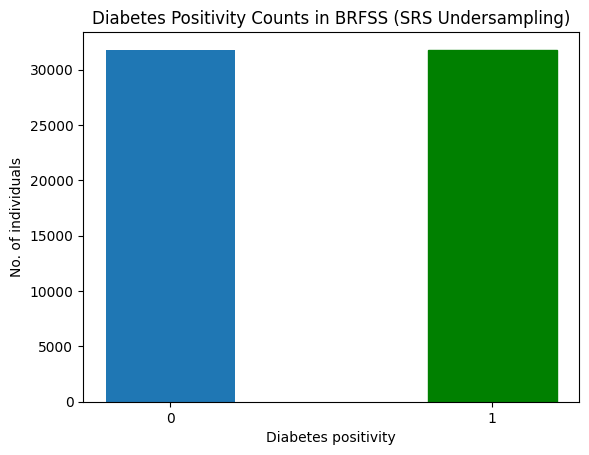

In [27]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Undersampling)")
plt.show()

In [28]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)

In [29]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50889, 20)
y_S_train: (50889,)
X_S_test: (12723, 20)
y_S_test: (12723,)


In [30]:
model_source_SRS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7737 - loss: 0.5635 - val_AUC: 0.8169 - val_loss: 0.5333
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8204 - loss: 0.5131 - val_AUC: 0.8209 - val_loss: 0.5195
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8245 - loss: 0.5088 - val_AUC: 0.8249 - val_loss: 0.5111
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8217 - loss: 0.5109 - val_AUC: 0.8251 - val_loss: 0.5083
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8258 - loss: 0.5063 - val_AUC: 0.8231 - val_loss: 0.5117
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8273 - loss: 0.5042 - val_AUC: 0.8261 - val_loss: 0.5075
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8335 - loss: 0.4964 - val_AUC: 0.8260 - val_loss: 0.5073
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8296 - loss: 0.5013 - val_AUC: 0.8268 - val_loss: 0.5065
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━━

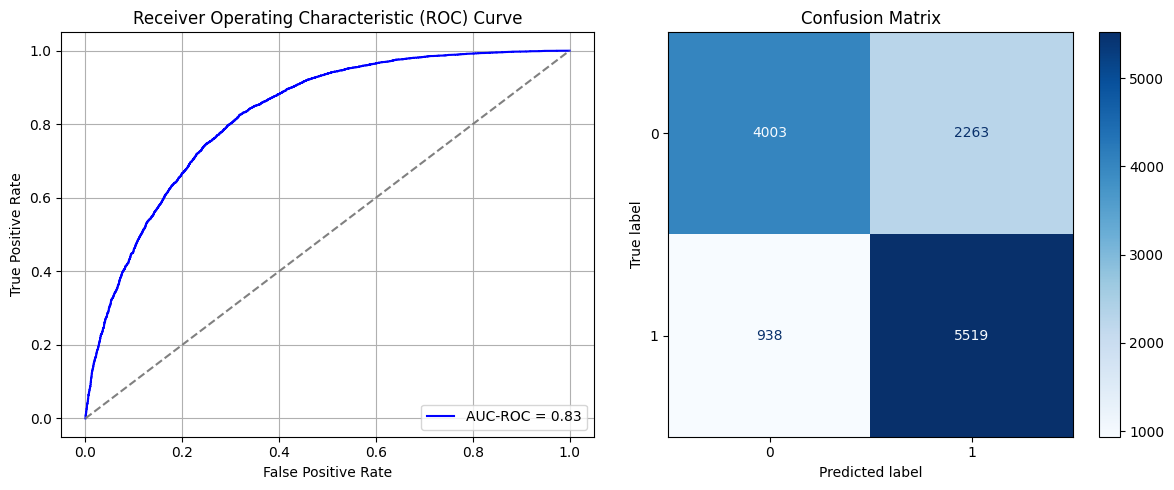

Best threshold based on F1-score: 0.43413296341896057
Time elapsed (performance): 39.56862132999959


<Sequential name=sequential_1, built=True>

In [31]:
train_and_evaluate(model_source_SRS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC-ROC: 0.8031387265106223
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.61      0.75     22957
         1.0       0.19      0.85      0.31      2411

    accuracy                           0.64     25368
   macro avg       0.58      0.73      0.53     25368
weighted avg       0.90      0.64      0.71     25368

FPR 0.38515485472840527 TPR: 0.8506843633347159 FNR: 0.1493156366652841 TNR: 0.6148451452715947


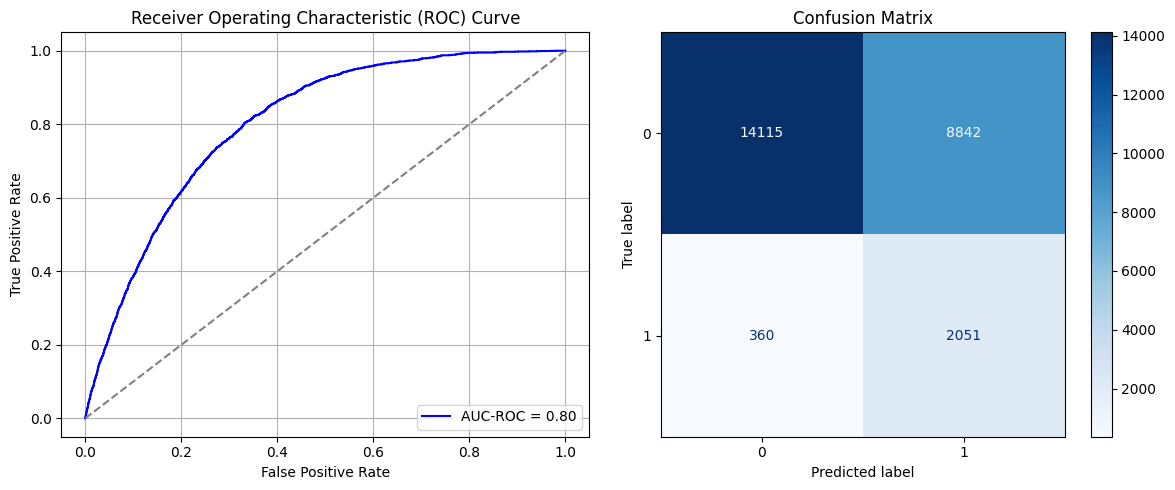

Best threshold based on F1-score: 0.9746568202972412
False Negative Rate: 0.1493156366652841
Time elapsed (performance): 1.8395745689995238


<ipython-input-16-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [32]:
Transductive_TL(model_source_SRS, data_T_X, data_T_y, "Target")

## Simple Random Sampling with Replacement:

In [20]:
data_S
data_S_majority = data_S_full[data_S_full['Diabetes_binary'].isin([0])]
data_S_minority = data_S_full[data_S_full['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

31806
196506


In [42]:
np.random.seed(123)
data_S_maj_rus = data_S_majority.sample(n=undersample_size, replace=True)
# print(data_S_maj_rus)

data_S_SRSwR_RUS = pd.concat([data_S_maj_rus, data_S_minority])
# print(data_S_SRS_RUS)

X_S_SRSwR = data_S_SRSwR_RUS.iloc[:, :20]
X_S_SRSwR      ## Source domain


y_S_SRSwR = data_S_SRSwR_RUS.iloc[:, 20]
y_S_SRSwR       ## Source classification (response)

,Diabetes_binary
90268,0
234280,0
53329,0
41182,0
132517,0
...,...
211634,1
207646,1
191755,1
92981,1


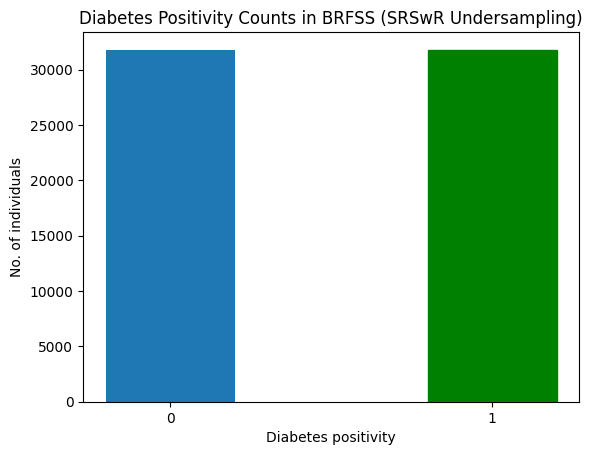

In [43]:
barlist = plt.bar([str(0),str(1)], y_S_SRSwR.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRSwR Undersampling)")
plt.show()

In [44]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRSwR, y_S_SRSwR, test_size=0.20, random_state=0)

In [45]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50889, 20)
y_S_train: (50889,)
X_S_test: (12723, 20)
y_S_test: (12723,)


In [46]:
model_source_SRSwR = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7802 - loss: 0.5599 - val_AUC: 0.8086 - val_loss: 0.5294
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8181 - loss: 0.5172 - val_AUC: 0.8164 - val_loss: 0.5179
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8217 - loss: 0.5136 - val_AUC: 0.8171 - val_loss: 0.5175
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8290 - loss: 0.5039 - val_AUC: 0.8179 - val_loss: 0.5158
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8263 - loss: 0.5064 - val_AUC: 0.8176 - val_loss: 0.5186
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8288 - loss: 0.5040 - val_AUC: 0.8186 - val_loss: 0.5174
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8296 - loss: 0.5028 - val_AUC: 0.8184 - val_loss: 0.5154
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8306 - loss: 0.5013 - val_AUC: 0.8186 - val_loss: 0.5183
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━━

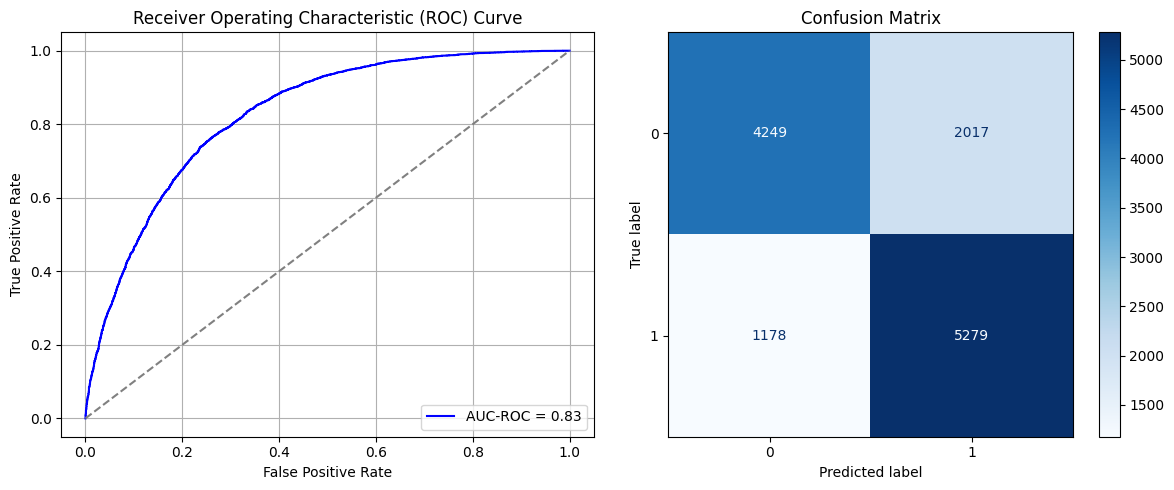

Best threshold based on F1-score: 0.4103652536869049
Time elapsed (performance): 40.09741949999989


<Sequential name=sequential_3, built=True>

In [47]:
train_and_evaluate(model_source_SRSwR, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC-ROC: 0.7984375582380614
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.65      0.78     22957
         1.0       0.20      0.81      0.32      2411

    accuracy                           0.67     25368
   macro avg       0.58      0.73      0.55     25368
weighted avg       0.90      0.67      0.74     25368

FPR 0.34599468571677483 TPR: 0.8087930319369556 FNR: 0.19120696806304438 TNR: 0.6540053142832252


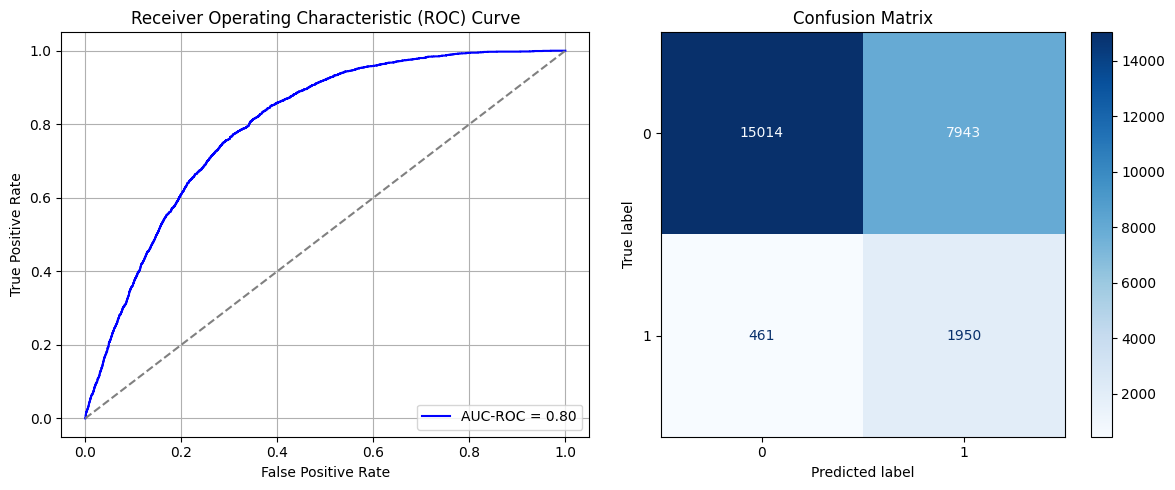

Best threshold based on F1-score: 0.6891887187957764
False Negative Rate: 0.19120696806304438
Time elapsed (performance): 1.915683948998776


In [48]:
Transductive_TL(model_source_SRSwR, data_T_X, data_T_y, "Target")

## Systematic Sampling:

First, we select a single systematic sample from the majority class, in which $k = \frac{N_0}{N_1}$, where $N_0$ is the majority class size in the source domain and $N_1$ is the minority class in the source domain.

In [21]:
import random

k = oversample_size/undersample_size
print(k)

np.random.seed(123)
start = random.randint(1, int(k))
print(start)


6.1782682512733444
2


In [50]:
data_S_majority.iloc[[1]]

,0,1,2,3,4,5,7,8,9,10,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
132821,1.0,1.0,1.0,0.186047,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.5,0.0,0.0,0.0,0.0,1.0,1.0,0.714286,0


In [22]:
Row = []

for i in range(undersample_size):
  row = start+int(k*i)-1
  Row.append(row)

print(Row)

data_S_maj_rus = pd.DataFrame()
data_S_maj_rus = data_S_majority.iloc[Row]

data_S_maj_rus


[1, 7, 13, 19, 25, 31, 38, 44, 50, 56, 62, 68, 75, 81, 87, 93, 99, 106, 112, 118, 124, 130, 136, 143, 149, 155, 161, 167, 173, 180, 186, 192, 198, 204, 211, 217, 223, 229, 235, 241, 248, 254, 260, 266, 272, 279, 285, 291, 297, 303, 309, 316, 322, 328, 334, 340, 346, 353, 359, 365, 371, 377, 384, 390, 396, 402, 408, 414, 421, 427, 433, 439, 445, 452, 458, 464, 470, 476, 482, 489, 495, 501, 507, 513, 519, 526, 532, 538, 544, 550, 557, 563, 569, 575, 581, 587, 594, 600, 606, 612, 618, 625, 631, 637, 643, 649, 655, 662, 668, 674, 680, 686, 692, 699, 705, 711, 717, 723, 730, 736, 742, 748, 754, 760, 767, 773, 779, 785, 791, 797, 804, 810, 816, 822, 828, 835, 841, 847, 853, 859, 865, 872, 878, 884, 890, 896, 903, 909, 915, 921, 927, 933, 940, 946, 952, 958, 964, 970, 977, 983, 989, 995, 1001, 1008, 1014, 1020, 1026, 1032, 1038, 1045, 1051, 1057, 1063, 1069, 1076, 1082, 1088, 1094, 1100, 1106, 1113, 1119, 1125, 1131, 1137, 1143, 1150, 1156, 1162, 1168, 1174, 1181, 1187, 1193, 1199, 1205, 1211

,0,1,2,3,4,5,7,8,9,10,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
132821,1.0,1.0,1.0,0.186047,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.50,0.000000,0.000000,0.0,0.0,1.000000,1.0,0.714286,0
159729,0.0,1.0,1.0,0.174419,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.50,0.000000,0.000000,0.0,1.0,0.750000,0.6,1.000000,0
159238,1.0,1.0,1.0,0.116279,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.25,1.000000,0.033333,0.0,0.0,0.833333,1.0,1.000000,0
94787,1.0,1.0,1.0,0.186047,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.50,0.033333,0.066667,0.0,0.0,0.916667,0.8,0.571429,0
132540,0.0,0.0,1.0,0.174419,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.25,0.000000,0.000000,0.0,1.0,0.750000,1.0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142173,1.0,0.0,1.0,0.162791,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.25,0.000000,0.000000,0.0,0.0,0.916667,0.8,0.714286,0
122747,1.0,0.0,1.0,0.360465,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.50,0.000000,0.000000,0.0,1.0,0.250000,0.4,0.571429,0
176092,0.0,0.0,1.0,0.139535,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.00,0.000000,0.000000,0.0,0.0,0.166667,0.8,1.000000,0
45310,1.0,1.0,1.0,0.186047,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.75,0.000000,0.000000,0.0,0.0,0.833333,0.8,0.714286,0


In [23]:
data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
# print(data_S_SRS_RUS)

X_S_Sy = data_S_Sy_RUS.iloc[:, :20]
X_S_Sy      ## Source domain


y_S_Sy = data_S_Sy_RUS.iloc[:, 20]
y_S_Sy       ## Source classification (response)

,Diabetes_binary
132821,0
159729,0
159238,0
94787,0
132540,0
...,...
211634,1
207646,1
191755,1
92981,1


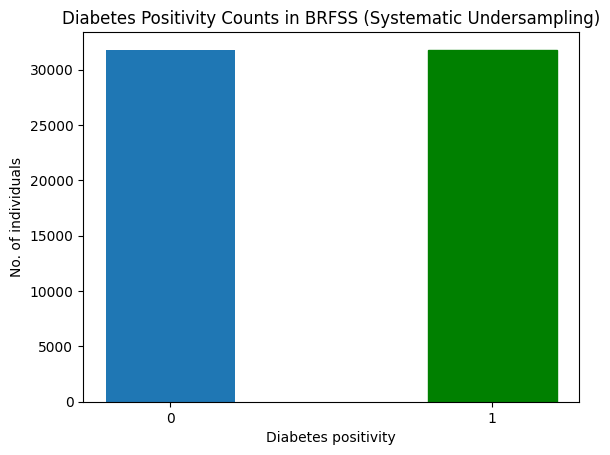

In [24]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Undersampling)")
plt.show()

In [25]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)

In [26]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50889, 20)
y_S_train: (50889,)
X_S_test: (12723, 20)
y_S_test: (12723,)


In [27]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7789 - loss: 0.5615 - val_AUC: 0.8171 - val_loss: 0.5274
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8156 - loss: 0.5196 - val_AUC: 0.8220 - val_loss: 0.5119
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8224 - loss: 0.5116 - val_AUC: 0.8231 - val_loss: 0.5107
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - AUC: 0.8229 - loss: 0.5109 - val_AUC: 0.8239 - val_loss: 0.5134
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8223 - loss: 0.5098 - val_AUC: 0.8243 - val_loss: 0.5109
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.8230 - loss: 0.5102 - val_AUC: 0.8263 - val_loss: 0.5061
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8275 - loss: 0.5053 - val_AUC: 0.8258 - val_loss: 0.5077
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8260 - loss: 0.5052 - val_AUC: 0.8252 - val_loss: 0.5091
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━━

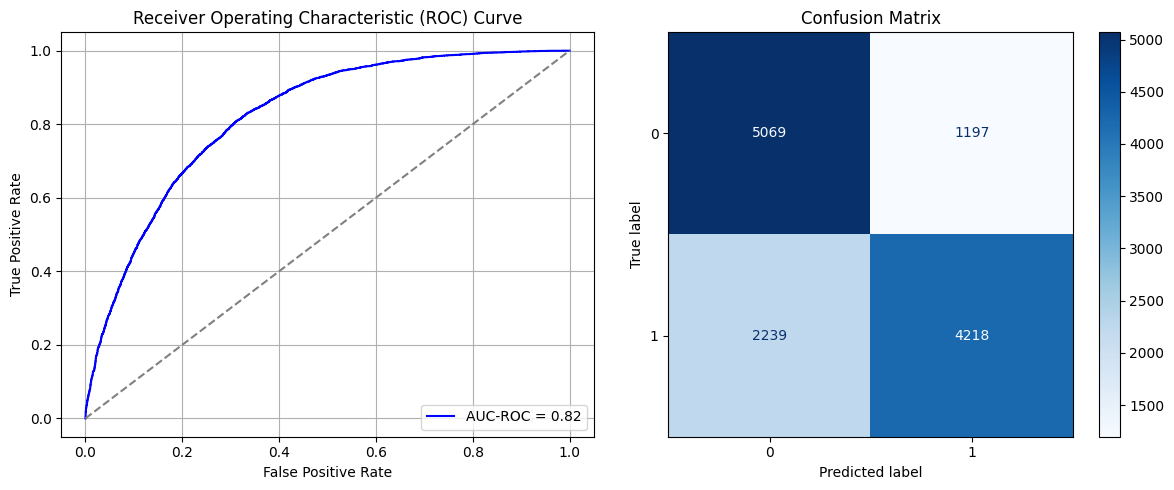

Best threshold based on F1-score: 0.2345690131187439
Time elapsed (performance): 47.38294497100003


<Sequential name=sequential, built=True>

In [28]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
AUC-ROC: 0.800767134892173
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.79      0.86     22957
         1.0       0.24      0.64      0.35      2411

    accuracy                           0.77     25368
   macro avg       0.60      0.71      0.61     25368
weighted avg       0.89      0.77      0.81     25368

FPR 0.21174369473363244 TPR: 0.6383243467440896 FNR: 0.3616756532559104 TNR: 0.7882563052663676


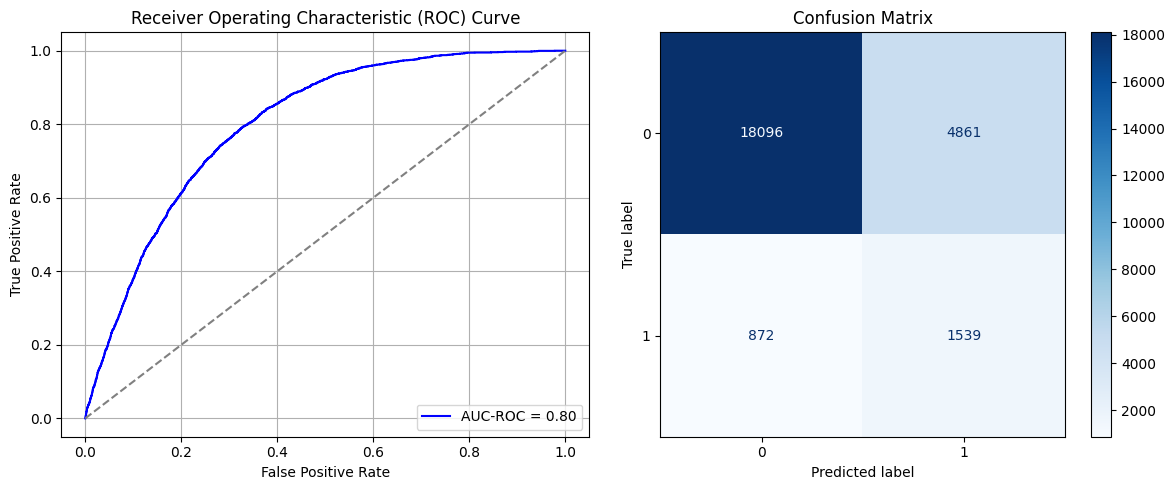

Best threshold based on F1-score: 0.5522577166557312
False Negative Rate: 0.3616756532559104
Time elapsed (performance): 6.4818381380000005


In [30]:
Transductive_TL(model_source_Sy, data_T_X, data_T_y, "Target")

## Systematic Sampling (multiple samples):

Now, we investigate the possibility of conducting $m$ systematic samples, each with a sampling interval of $k=m*\frac{N_0}{N_1}$, and obtaining the undersampled majority class data using all $m$ systematic samples combined. This may more closely approximate SRS sampling.

For convenience, we take $m=10$ in this case.

In [31]:
import random

m = 10

k = oversample_size/undersample_size * m
print(k)

np.random.seed(123)
start = random.sample(range(1, int(k)), 10)
# random.randint(1, int(k))
print(start)

61.782682512733444
[4, 29, 5, 7, 38, 45, 14, 19, 59, 51]


In [32]:
Row = []

for j in range(len(start)):
  for i in range(int(undersample_size/m)):
    row = start[j]+int(k*i)-1
    Row.append(row)

# print(Row)

data_S_maj_rus = pd.DataFrame()
data_S_maj_rus = data_S_majority.iloc[Row]

data_S_maj_rus

,0,1,2,3,4,5,7,8,9,10,...,12,13,14,15,16,17,18,19,20,Diabetes_binary
139717,0.0,0.0,1.0,0.174419,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.25,0.100000,0.000000,0.0,1.0,0.083333,0.6,0.857143,0
190381,0.0,0.0,1.0,0.116279,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.25,0.000000,0.000000,0.0,0.0,0.500000,0.8,1.000000,0
146852,0.0,0.0,1.0,0.186047,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.25,0.666667,0.166667,0.0,1.0,0.416667,0.6,0.142857,0
249723,0.0,0.0,1.0,0.313953,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.50,0.000000,0.000000,0.0,0.0,0.250000,1.0,0.714286,0
34770,0.0,1.0,1.0,0.162791,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.25,0.066667,0.466667,0.0,0.0,0.083333,0.6,0.571429,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159574,0.0,1.0,1.0,0.127907,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.00,0.000000,0.000000,0.0,1.0,0.666667,1.0,1.000000,0
201671,0.0,0.0,1.0,0.116279,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.25,0.000000,0.133333,0.0,1.0,0.083333,1.0,0.571429,0
135425,0.0,0.0,1.0,0.197674,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.50,0.000000,0.000000,0.0,0.0,0.666667,0.6,0.857143,0
68617,1.0,1.0,1.0,0.290698,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.50,0.133333,0.000000,0.0,1.0,0.833333,1.0,1.000000,0


In [33]:
data_S_Sy_RUS = pd.concat([data_S_maj_rus, data_S_minority])
# print(data_S_SRS_RUS)

X_S_Sy = data_S_Sy_RUS.iloc[:, :20]
X_S_Sy      ## Source domain


y_S_Sy = data_S_Sy_RUS.iloc[:, 20]
y_S_Sy       ## Source classification (response)

,Diabetes_binary
139717,0
190381,0
146852,0
249723,0
34770,0
...,...
211634,1
207646,1
191755,1
92981,1


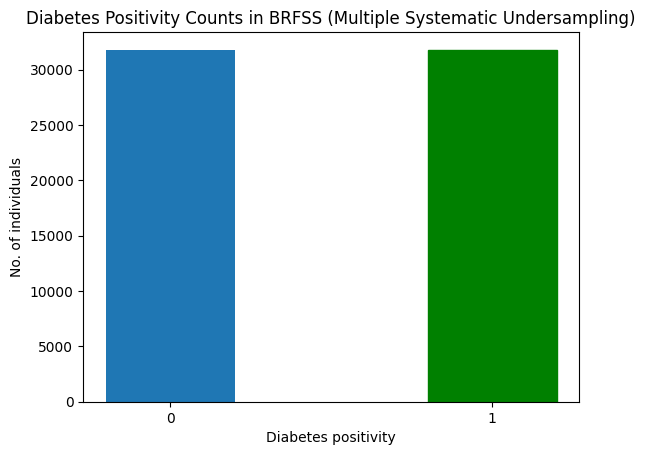

In [34]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Multiple Systematic Undersampling)")
plt.show()

In [35]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)

In [36]:
print('X_S_train:',np.shape(X_S_train))
print('y_S_train:',np.shape(y_S_train))
print('X_S_test:',np.shape(X_S_test))
print('y_S_test:',np.shape(y_S_test))

X_S_train: (50884, 20)
y_S_train: (50884,)
X_S_test: (12722, 20)
y_S_test: (12722,)


In [37]:
model_source_Sy = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.7751 - loss: 0.5652 - val_AUC: 0.8144 - val_loss: 0.5311
Epoch 2/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8148 - loss: 0.5202 - val_AUC: 0.8198 - val_loss: 0.5157
Epoch 3/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.8191 - loss: 0.5142 - val_AUC: 0.8207 - val_loss: 0.5154
Epoch 4/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - AUC: 0.8229 - loss: 0.5103 - val_AUC: 0.8201 - val_loss: 0.5156
Epoch 5/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8250 - loss: 0.5072 - val_AUC: 0.8188 - val_loss: 0.5261
Epoch 6/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8259 - loss: 0.5070 - val_AUC: 0.8215 - val_loss: 0.5173
Epoch 7/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8238 - loss: 0.5092 - val_AUC: 0.8210 - val_loss: 0.5194
Epoch 8/10
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.8293 - loss: 0.5029 - val_AUC: 0.8218 - val_loss: 0.5138
Epoch 9/10
1273/1273 ━━━━━━━━━━━━━━━━━━━

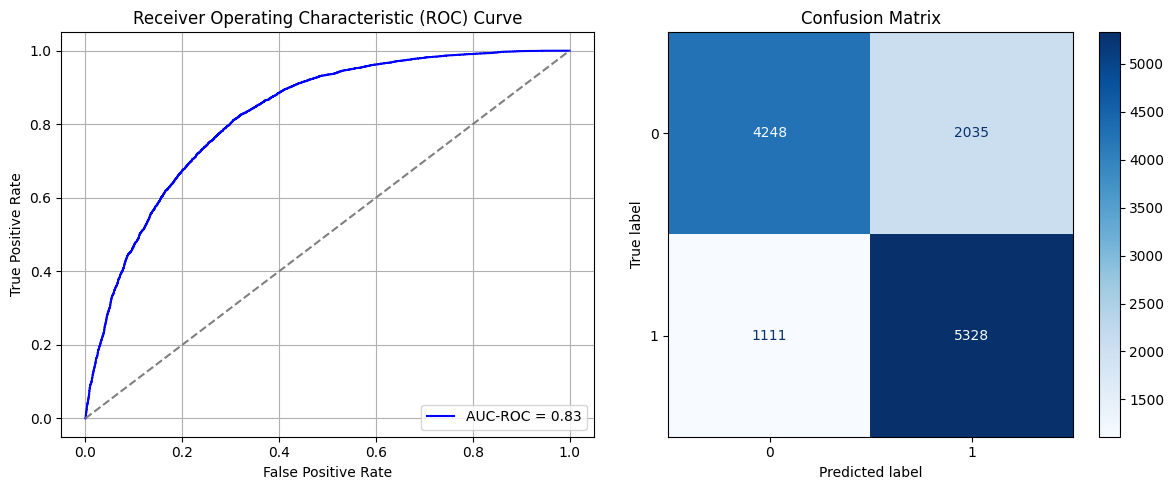

Best threshold based on F1-score: 0.4066475033760071
Time elapsed (performance): 35.908057740000004


<Sequential name=sequential_1, built=True>

In [38]:
train_and_evaluate(model_source_Sy, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
AUC-ROC: 0.8017016268327888
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.65      0.78     22957
         1.0       0.20      0.82      0.32      2411

    accuracy                           0.67     25368
   macro avg       0.58      0.73      0.55     25368
weighted avg       0.90      0.67      0.73     25368

FPR 0.3511347301476674 TPR: 0.8187474077146413 FNR: 0.18125259228535878 TNR: 0.6488652698523326


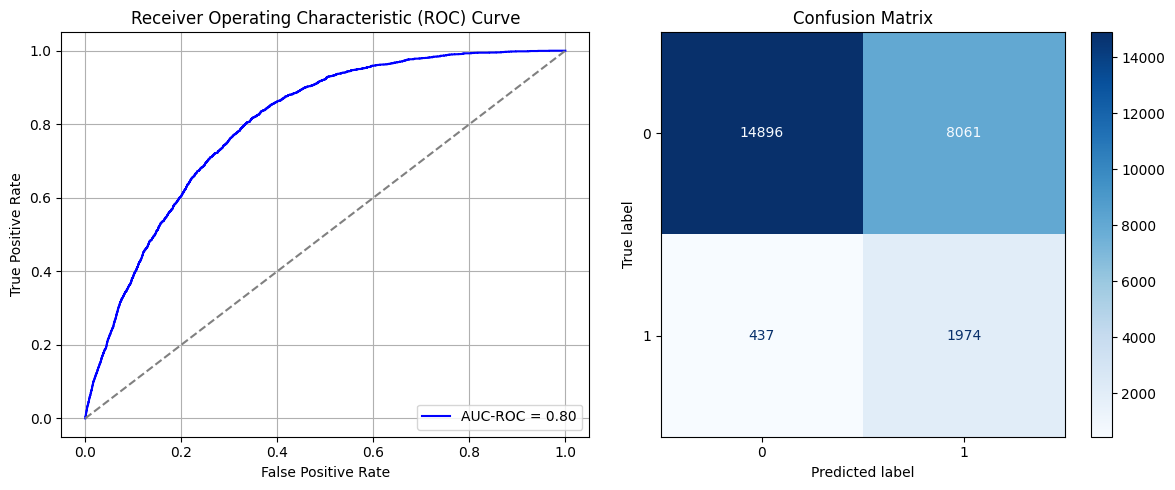

Best threshold based on F1-score: 0.6976838707923889
False Negative Rate: 0.18125259228535878
Time elapsed (performance): 2.5230169690000253


In [39]:
Transductive_TL(model_source_Sy, data_T_X, data_T_y, "Target")

# Random Oversampling (ROS):

## Simple Random Sampling with Replacement:

In this case, we investigate the effectiveness of Random Oversampling methods, beginning with Simple Random Sampling (SRS) with replacement. For this, we perform random resampling from the minority class of size $N_1$ to generate an additional sample of size $N_0-N_1$, such that the oversampled minority class will have the same size as the majority class.

In [40]:
data_S_full
data_S_majority = data_S_full[data_S_full['Diabetes_binary'].isin([0])]
data_S_minority = data_S_full[data_S_full['Diabetes_binary'].isin([1])]

undersample_size = data_S_minority['Diabetes_binary'].size
oversample_size = data_S_majority['Diabetes_binary'].size

print(undersample_size)
print(oversample_size)

31806
196506


In [41]:
np.random.seed(123)
data_S_min_ros = data_S_minority.sample(n=oversample_size - undersample_size, replace=True)
# print(data_S_min_ros)

data_S_SRS_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
# print(data_S_SRS_ROS)

X_S_SRS = data_S_SRS_ROS.iloc[:, :20]
X_S_SRS      ## Source domain


y_S_SRS = data_S_SRS_ROS.iloc[:, 20]
y_S_SRS       ## Source classification (response)

,Diabetes_binary
219620,0
132821,0
151862,0
139717,0
239235,0
...,...
211634,1
207646,1
191755,1
92981,1


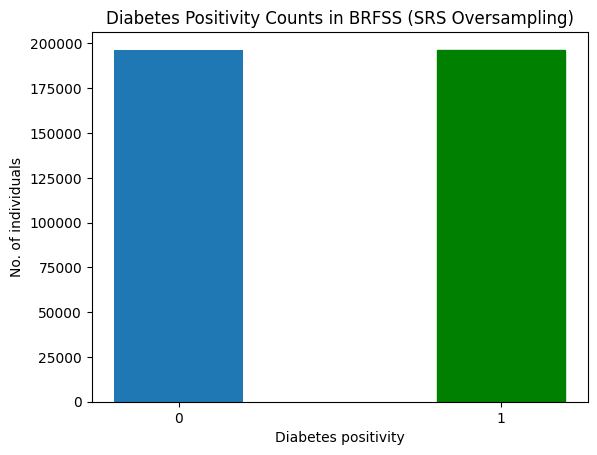

In [42]:
barlist = plt.bar([str(0),str(1)], y_S_SRS.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (SRS Oversampling)")
plt.show()

In [43]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_SRS, y_S_SRS, test_size=0.20, random_state=0)

In [44]:
model_source_SRS_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - AUC: 0.8068 - loss: 0.5295 - val_AUC: 0.8262 - val_loss: 0.5085
Epoch 2/10
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - AUC: 0.8253 - loss: 0.5074 - val_AUC: 0.8272 - val_loss: 0.5063
Epoch 3/10
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8284 - loss: 0.5037 - val_AUC: 0.8282 - val_loss: 0.5076
Epoch 4/10
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8286 - loss: 0.5030 - val_AUC: 0.8281 - val_loss: 0.5049
Epoch 5/10
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8288 - loss: 0.5024 - val_AUC: 0.8306 - val_loss: 0.5012
Epoch 6/10
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8293 - loss: 0.5015 - val_AUC: 0.8294 - val_loss: 0.5044
Epoch 7/10
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8310 - loss: 0.4995 - val_AUC: 0.8294 - val_loss: 0.5067
Epoch 8/10
7861/7861 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8323 - loss: 0.4984 - val_AUC: 0.8303 - val_loss: 0.5020
Epoch 9/10
7861/7861 ━━━━━━━━━━━

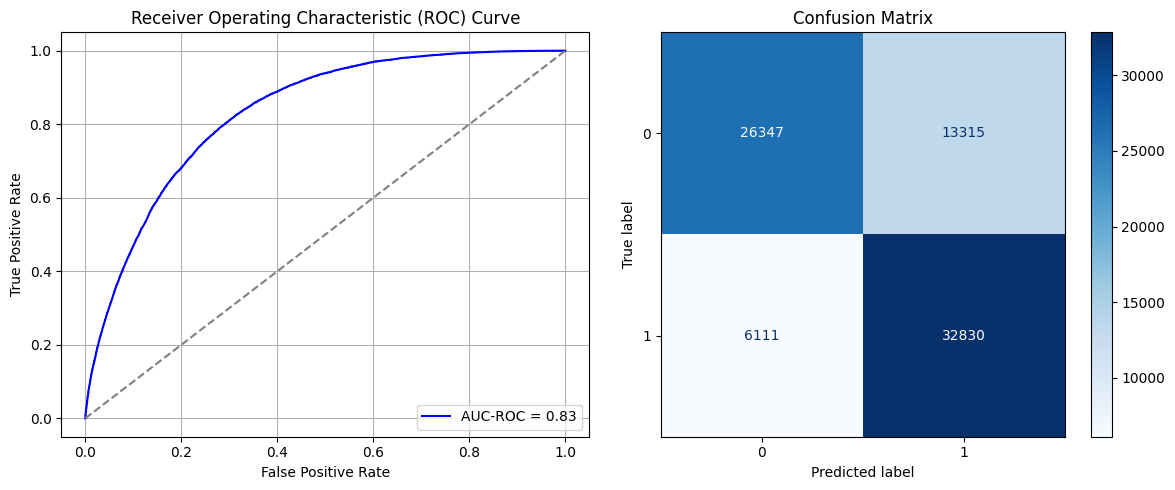

Best threshold based on F1-score: 0.4368688762187958
Time elapsed (performance): 203.80873560199996


<Sequential name=sequential_2, built=True>

In [45]:
train_and_evaluate(model_source_SRS_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

793/793 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
AUC-ROC: 0.8006283978845851
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.64      0.77     22957
         1.0       0.19      0.83      0.32      2411

    accuracy                           0.66     25368
   macro avg       0.58      0.73      0.54     25368
weighted avg       0.90      0.66      0.73     25368

FPR 0.35862699830117173 TPR: 0.826627955205309 FNR: 0.173372044794691 TNR: 0.6413730016988283


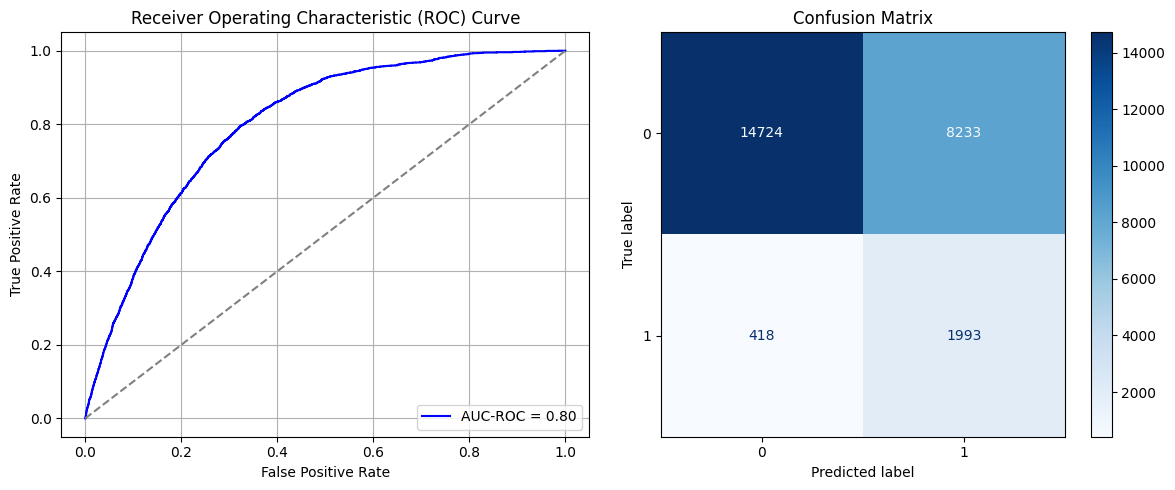

Best threshold based on F1-score: 0.7141225934028625
False Negative Rate: 0.173372044794691
Time elapsed (performance): 3.1416378399999303


In [46]:
Transductive_TL(model_source_SRS_ROS, data_T_X, data_T_y, "Target")

## Systematic Resampling:

In this case, we examine the possibility of performing Random Oversampling on the minority class using systematic sampling. For this purpose, taking a sampling interval of $k$, we would compile a total of $k*\frac{N_0-N_1}{N_1}$ systematic samples from the minority class in order to balance the dataset. We sample the starting point from 1 to $k$ *with replacement*, since a highly imbalanced dataset will require sampling with replacement in order to achieve a balanced dataset.

In particular, taking $k=48$ yields a number of samples of $k*\frac{N_0-N_1}{N_1}=254.986 \approx 255$, so we take $k=48$.

In [48]:
import random

k = 48

Nsamples = k*(oversample_size-undersample_size)/undersample_size
# print(Nsamples)

np.random.seed(123)
start = np.random.choice(int(k), int(Nsamples), replace=True)
# print(start)


Row = []

for j in range(len(start)):
  for i in range(int(undersample_size/k)):
    row = start[j]+int(k*i)-1
    Row.append(row)

# print(Row)

data_S_min_ros = pd.DataFrame()
data_S_min_ros = data_S_minority.iloc[Row]

data_S_Sy_ROS = pd.concat([data_S_majority, data_S_min_ros, data_S_minority])
# print(data_S_SRS_ROS)

X_S_Sy = data_S_Sy_ROS.iloc[:, :20]
X_S_Sy      ## Source domain


y_S_Sy = data_S_Sy_ROS.iloc[:, 20]
y_S_Sy       ## Source classification (response)




,Diabetes_binary
219620,0
132821,0
151862,0
139717,0
239235,0
...,...
211634,1
207646,1
191755,1
92981,1


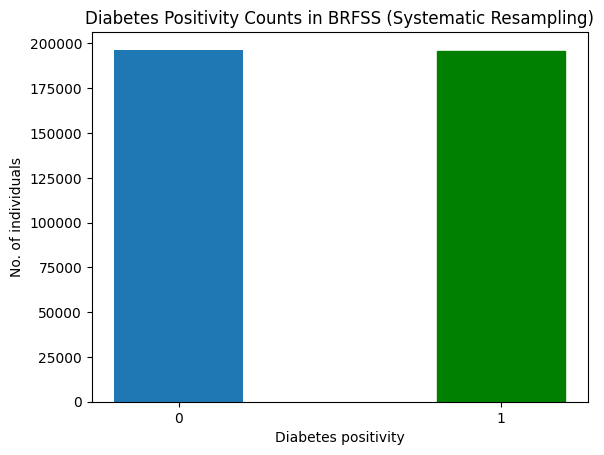

In [49]:
barlist = plt.bar([str(0),str(1)], y_S_Sy.value_counts(), width = 0.4)
barlist[1].set_color('g')

plt.xlabel("Diabetes positivity")
plt.ylabel("No. of individuals")
plt.title("Diabetes Positivity Counts in BRFSS (Systematic Resampling)")
plt.show()

In [50]:
X_S_train, X_S_test, y_S_train, y_S_test = train_test_split(X_S_Sy, y_S_Sy, test_size=0.20, random_state=0)

In [51]:
model_source_Sy_ROS = create_dnn_model(X_S_train.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7850/7850 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - AUC: 0.8078 - loss: 0.5286 - val_AUC: 0.8269 - val_loss: 0.5059
Epoch 2/10
7850/7850 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.8258 - loss: 0.5068 - val_AUC: 0.8290 - val_loss: 0.5258
Epoch 3/10
7850/7850 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8281 - loss: 0.5046 - val_AUC: 0.8297 - val_loss: 0.5018
Epoch 4/10
7850/7850 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - AUC: 0.8294 - loss: 0.5026 - val_AUC: 0.8299 - val_loss: 0.5027
Epoch 5/10
7850/7850 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8294 - loss: 0.5022 - val_AUC: 0.8308 - val_loss: 0.5004
Epoch 6/10
7850/7850 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - AUC: 0.8320 - loss: 0.4991 - val_AUC: 0.8319 - val_loss: 0.4985
Epoch 7/10
7850/7850 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - AUC: 0.8327 - loss: 0.4981 - val_AUC: 0.8317 - val_loss: 0.5024
Epoch 8/10
7850/7850 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - AUC: 0.8344 - loss: 0.4958 - val_AUC: 0.8306 - val_loss: 0.5025
Epoch 9/10
7850/7850 ━━━━━━━━━━━

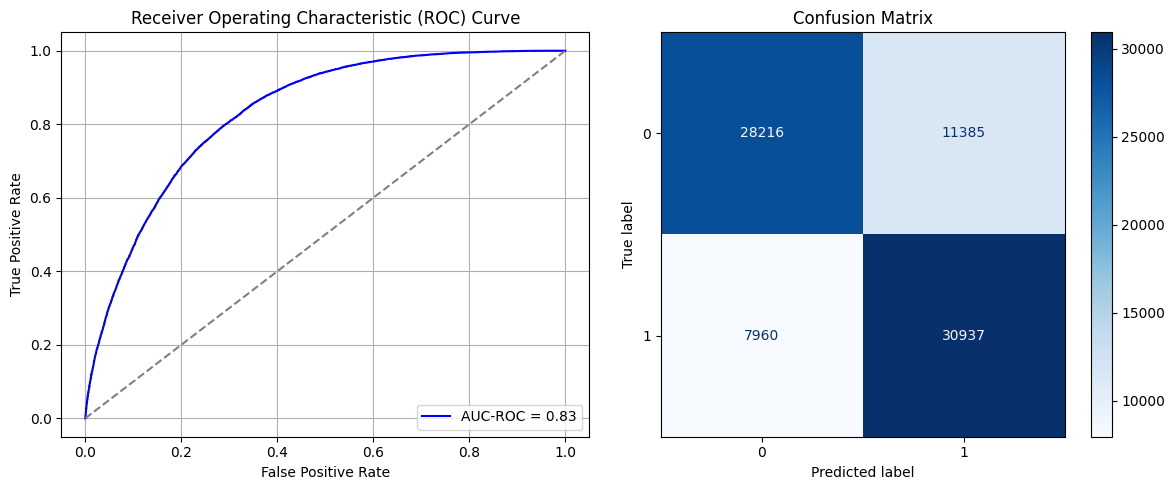

Best threshold based on F1-score: 0.40383827686309814
Time elapsed (performance): 192.85660022499997


<Sequential name=sequential_3, built=True>

In [52]:
train_and_evaluate(model_source_Sy_ROS, X_S_train, X_S_test, y_S_train, y_S_test, "Source")

793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
AUC-ROC: 0.7941599271839385
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81     22957
         1.0       0.21      0.77      0.33      2411

    accuracy                           0.70     25368
   macro avg       0.59      0.73      0.57     25368
weighted avg       0.89      0.70      0.76     25368

FPR 0.3077057106764821 TPR: 0.7660721692243883 FNR: 0.23392783077561177 TNR: 0.6922942893235179


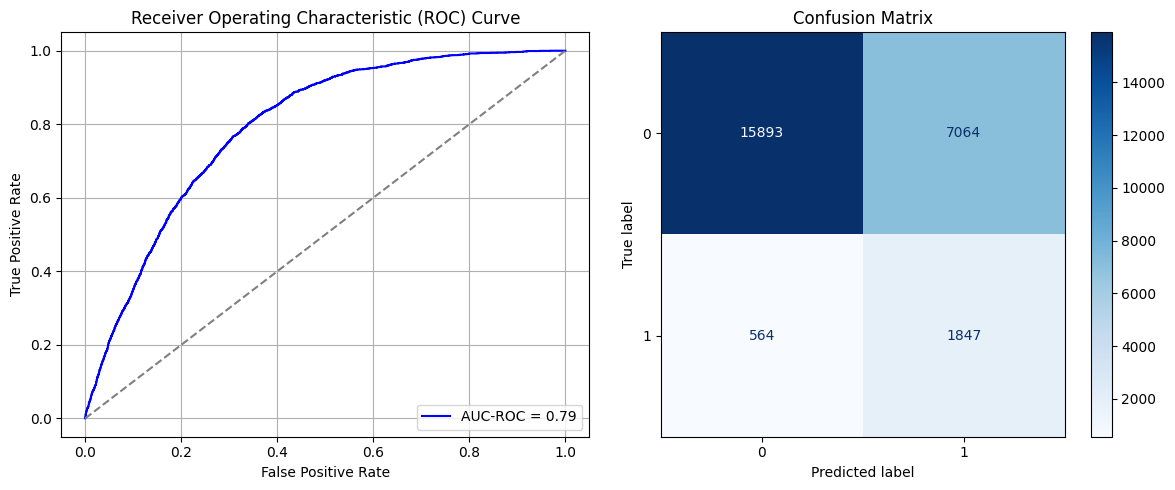

Best threshold based on F1-score: 0.9441724419593811
False Negative Rate: 0.23392783077561177
Time elapsed (performance): 6.228348745000176


<ipython-input-17-de1f6cb50f3b>:54: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [54]:
Transductive_TL(model_source_Sy_ROS, data_T_X, data_T_y, "Target")